In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip


In [2]:
!unzip '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip'
!unzip '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip'
!unzip '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip'
!unzip '/kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip'


Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv.zip
  inflating: train.csv               
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv.zip
  inflating: test.csv                
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  /kaggle/input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
  inflating: sample_submission.csv   


In [3]:
### Import Libraries 
import re
import nltk
import matplotlib
from collections import OrderedDict
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
import seaborn as sns
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from itertools import combinations
import networkx as nx
import torch
from sklearn import preprocessing
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from keras.models import Sequential
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from keras.layers import Dense, LSTM, Embedding, Input
from sklearn.model_selection import train_test_split


In [4]:
### Reading csv data files using pandas dataframe 

train = pd.read_csv("./train.csv", encoding = "ISO-8859-1")


In [5]:
### Checking nulls in both the datasets

print("Nulls in training dataset",train.isnull().sum())

### There are no missing values in both the datasets

Nulls in training dataset id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


In [6]:
### Before cleaning the dataset I would like to perform EDA(Exploratory data analysis) by performing data visualization to understand
### the distribution of different classes. I will be performing EDA on training dataset

categorywise_data = train.drop(['id', 'comment_text'], axis=1)     ### Removed unnecessary columns - id and comment_text
counts_category = []                                               ### A list that contains tuple which consists of class label and number of comments for that particular class 
categories = list(categorywise_data.columns.values)
for i in categories:
    counts_category.append((i, categorywise_data[i].sum()))
    
dataframe = pd.DataFrame(counts_category, columns=['Labels', 'number_of_comments'])   ### Dataframe made up of category and total number of comments

Text(0.5, 0, 'Labels')

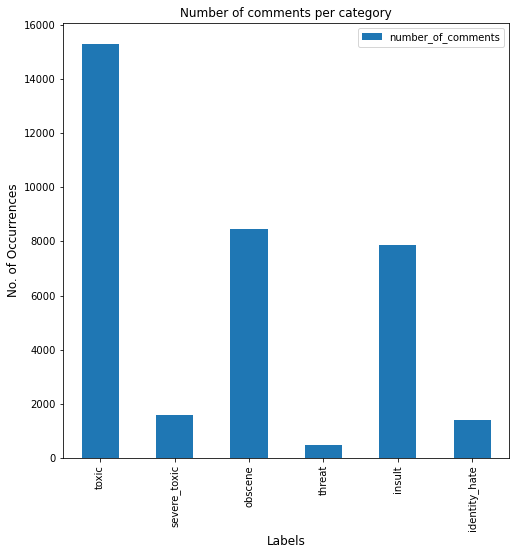

In [7]:
### Visualization 1

### Bar graph of total number of comments per label 
### This visualization is helpful in identifying the total number of comments per label
dataframe.plot(x='Labels', y='number_of_comments', kind='bar',figsize=(8,8))
plt.title("Number of comments per category")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)

### From the below graph we can observe that most of the comments having toxic label. 
### Threat label is having lowest no. of comments

,0,Total no. of sentences,Total No. of labels in a sentence
0,143346,143346,0
1,6360,6360,1
3,4209,4209,3
2,3480,3480,2
4,1760,1760,4
5,385,385,5
6,31,31,6


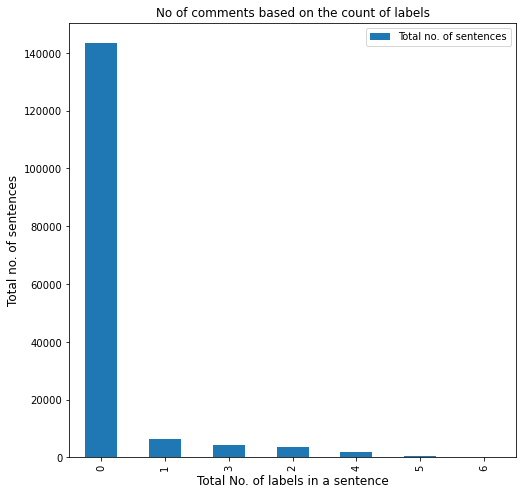

In [8]:
### Visualization 2

### Bar graph of Total No. of labels in a sentence against Total no. of sentences
### This visualization is helpful in identifying whether a sentence belongs to only one category or many categories

dataframe = pd.DataFrame(pd.DataFrame(train[train.columns[2:]].sum(axis=1)).reset_index()[0].value_counts())
dataframe["Total no. of sentences"]=dataframe[0]
dataframe["Total No. of labels in a sentence"]=dataframe.index
dataframe.plot(x="Total No. of labels in a sentence", y="Total no. of sentences", kind='bar',figsize=(8,8))
plt.title("No of comments based on the count of labels")
plt.ylabel('Total no. of sentences', fontsize=12)
plt.xlabel('Total No. of labels in a sentence', fontsize=12)
dataframe

### From the below graph we can see that 1,43,346 out of 1,59,571 sentences does not have any labels(class 0).
### we can observe that a single sentence can have multiple labels. It can be a toxic sentence or it can be a toxic as well as obscene senetence.

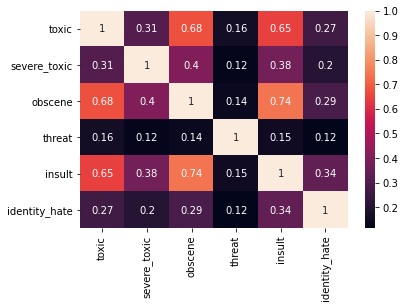

In [9]:
### Visualization 4

### Correlation between different variables
### Correlation helps us finding relationship/dependency between different variables. 

target_data = train.drop(['id', 'comment_text'], axis=1)
corrMatrix = target_data.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

### Correlation coefficient ranges from -1 to 1. Values always range between -1 imply strong negative relationship
### between variables and +1 imply a strong positive relationship between variables. 
### Values at or close to zero imply weak or no linear relationship. 
### From the correlation matrix(graph), it can be concluded that some labels are highely correlated. Those varibles are mentioned below 
### (Correlation coefficient for insult-obscene is 0.74, Correlation coefficient for toxic-obscene is 0.68 and Correlation coefficient for toxic-insult is 0.65).

In [10]:
### Data cleaning/Preparation 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)      ### conversion of contraction words to expanded words
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)                                                 ### removing non-word characters
    text = re.sub('[^A-Za-z\' ]+', '',text)                                        ### removing all non-alphanumeric values(Except single quotes)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = ' '.join([word for word in text.split() if word not in (stop_words)])    ### Stopwords removal
    return text

train["comment_text"] = train["comment_text"].apply(clean_text)


In [11]:
### Splitting up the labels and data
### Training dataset is splitted into 2 parts. 1st part includes the training data(train_data) and 2nd part includes labels(train_label) 
### associated with the training data
### Test dataset is having only 1 part i.e. test data which is used to predict the labels. 

train_data = train["comment_text"]
# test_data = test["comment_text"]
train_label=train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]


In [12]:
train_data=train_data.iloc[:5000,].copy()
train_label=train_label.iloc[:5000,].copy()
del(train)
import gc

gc.collect()

10093

In [13]:
#Tokenization and Lematization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

train_data=train_data.apply(lemmatize_text)


In [14]:
#Removing Stop words
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text
train_data=train_data.apply(lambda x: remove_stopwords(x))

In [15]:
#Computing Tf-idf Matrix
tvec = TfidfVectorizer(min_df=.0025, max_df=.1)
tvec_weights = tvec.fit_transform(train_data.map(str))
vocab =tvec.get_feature_names()
vocab = np.array(vocab)
df_tfidf = pd.DataFrame(tvec_weights.toarray(),columns=vocab)

# **Computing the graph and Building the Model**

In this Section we will Compute the Graph based On the research Paper Method 
"Graph Convolutional Networks for Text Classification
Liang Yao, Chengsheng Mao, Yuan Luo"

This is The method we used from the research paper to implement the
graph
Formally, the weight of edge between node $i$ as node $j$ is defined as
$$
A_{i j}=\left\{\begin{array}{ll}
\operatorname{PMI}(i, j) & i, j \text { are words }, \operatorname{PMI}(i, j)>0 \\
T F-I D F_{i j} & i \text { is the class }, j \text { is word } \\
1 & i=j \\
0 & \text { otherwise }
\end{array}\right.
$$
The PMI value of a word pair $i, j$ is computed as
$$
\begin{aligned}
\operatorname{PMI}(i, j) &=\log \frac{p(i, j)}{p(i) p(j)} \\
p(i, j) &=\frac{\# W(i, j)}{\# W} \\
p(i) &=\frac{\# W(i)}{\# I W}
\end{aligned}
$$
where $\# W(i)$ is the number of sliding windows in a corpus that contain word i, $\# W(i,j)$ is the number of sliding windows in a corpus that contain both word i and j, $\# W$ is the
total number of sliding windows in the corpus.

In [16]:
### PMI between words
window = 7# sliding window size to calculate point-wise mutual information between words
names = vocab
n_i  = OrderedDict((name, 0) for name in names)
word2index = OrderedDict( (name,index) for index,name in enumerate(names) )
occurrences = np.zeros( (len(names),len(names)) ,dtype=np.int32)

# Find the co-occurrences:
no_windows = 0
for l in tqdm(train_data,total=len(train_data)):
    for i in range(len(l)-window):
        no_windows += 1
        d = set(l[i:(i+window)])
        for w in d:
             if w in vocab:
                n_i[w] += 1
        for w1,w2 in combinations(d,2):
            
             if w1 in vocab and w2 in vocab:
                i1 = word2index[w1]
                i2 = word2index[w2]

                occurrences[i1][i2] += 1
                occurrences[i2][i1] += 1

### convert to PMI
p_ij = pd.DataFrame(occurrences, index = names,columns=names)/no_windows
p_i = pd.Series(n_i, index=n_i.keys())/no_windows

for col in p_ij.columns:
    p_ij[col] = p_ij[col]/p_i[col]
for row in p_ij.index:
    p_ij.loc[row,:] = p_ij.loc[row,:]/p_i[row]
p_ij = p_ij + 1E-9
for col in p_ij.columns:
    p_ij[col] = p_ij[col].apply(lambda x: np.log(x))


100%|██████████| 5000/5000 [03:19<00:00, 25.11it/s]


In [17]:
def word_word_edges(p_ij):
    word_word = []
    cols = list(p_ij.columns); cols = [str(w) for w in cols]
    for w1, w2 in tqdm(combinations(cols, 2),):
        if (p_ij.loc[w1,w2] > 0):
            word_word.append((w1,w2,{"weight":p_ij.loc[w1,w2]}))
    return word_word
    
### Build graph
G = nx.Graph()
G.add_nodes_from(df_tfidf.index) ## document nodes
G.add_nodes_from(vocab) ## word nodes
### build edges between document-word pairs
document_word = [(doc,w,{"weight":df_tfidf.loc[doc,w]}) for doc in df_tfidf.index for w in df_tfidf.columns]
del(df_tfidf)
gc.collect()
G.add_edges_from(document_word)
### build edges between word-word pairs
word_word = word_word_edges(p_ij)
G.add_edges_from(word_word)

1519896it [00:20, 73817.44it/s]


Here We will build The GCN
$$
Z=\operatorname{softmax}\left(\tilde{A} \operatorname{Rel} U\left(\tilde{A} X W_{0}\right) W_{1}\right)
$$
where $\tilde{A}=D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$  and $\operatorname{softmax}\left(x_{i}\right)=\frac{1}{2} \exp \left(x_{i}\right)$ with $\mathcal{Z}=\sum \exp (x)$. $A$ is the Identity matrix as defined below
and $D$ is defined such as $ D_{i i}=\sum_{j} A_{i j}$

In [18]:
class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class,A_hat, dropout=0):
        super(GNN, self).__init__()
        A_hat_tensor=torch.tensor(A_hat, requires_grad=False).float()
        self.A_hat = A_hat_tensor.to('cuda:0')
        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2) 
#         self.fc3 = nn.Linear(n_hidden_2, n_hidden_2)
        self.fc4 = nn.Linear(n_hidden_2, n_class)
        # self.norm1=torch.nn.LayerNorm()
        # self.norm2=torch.nn.LayerNorm()
        # self.norm3=torch.nn.LayerNorm()


        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        ############## Tasks 10 and 13
        
        ##################
        x1 = torch.mm(x,self.fc1.weight.t())
        x1 = torch.mm(self.A_hat,x1)
        x1 = self.dropout(self.relu(x1))

        
        x2 = torch.mm(x1,self.fc2.weight.t())
        x2 = torch.mm(self.A_hat,x2)
        x2 = self.dropout(self.relu(x2))

      
        x =  torch.mm(x2,self.fc4.weight.t())
        ##################

        return F.log_softmax(x, dim=1)


In this Cell we will compute the adjacency matrix A


In [19]:
#computing 
A = nx.to_numpy_matrix(G, weight="weight"); A = A + np.eye(G.number_of_nodes())
degrees = []
for d in G.degree(weight=None):
    if d == 0:
        degrees.append(0)
    else:
        degrees.append(d[1]**(-0.5))
degrees = np.diag(degrees)
X = np.eye(G.number_of_nodes()) # Features are just identity matrix
A_hat = degrees@A@degrees
f = X
del(G)

In [20]:
#transforming classes vectors into one vector
y=train_label
y['severe_toxic']=2*y['severe_toxic']
y['obscene']=3*y['obscene']
y['threat']=4*y['threat']
y['insult']=5*y['insult']
y['identity_hate']=6*y['identity_hate']
y=np.argmax(y.values, axis=1)

In [21]:
#Selecting train, test indexes 
test_idxs = []
for b_id in np.unique(y):
    dum = train_data[y== b_id]
    if len(dum) >= 4:
      test_idxs.extend(list(np.random.choice(dum.index, size=round(0.2*len(dum)), replace=False)))

# select only certain labelled nodes for semi-supervised GCN

selected = []
for i in range(len(train_data)):
    if i not in test_idxs:
        selected.append(i)

f = torch.from_numpy(f).float()

In [22]:
hidden_size_1,hidden_size_2 = 100, 100 #I d'idn't have time to optimise the architecture
lr=0.01
losses_per_epoch=[]
num_epochs = 2500
net = GNN(X.shape[1], A_hat = A_hat,n_class=6,n_hidden_1 = hidden_size_1, n_hidden_2=hidden_size_2)
criterion= torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=lr)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000,2000,3000,4000],gamma=0.5)
f=f.to('cuda:0')
net = net.to('cuda:0')
net.train()

evaluation_trained = []
for e in range( num_epochs):
    optimizer.zero_grad()
    output = net(f)
    k=torch.tensor(y[selected])
    loss = criterion(output[selected],k.to('cuda:0'))
    print(loss)
    losses_per_epoch.append(loss.item())
    loss.backward()
    optimizer.step()
    net.eval()
    with torch.no_grad():
      pred_labels = net(f)
      trained_accuracy = accuracy_score(output[selected].cpu().max(1)[1], y[selected] )
      test_accuracy = accuracy_score(output[test_idxs].cpu().max(1)[1],y[test_idxs])
      print("[Epoch %d]: Evaluation accuracy of trained nodes: %.7f" % (e, trained_accuracy))
      print("[Epoch %d]: Evaluation accuracy of test nodes: %.7f" % (e, test_accuracy))
      net.train()


tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[Epoch 0]: Evaluation accuracy of trained nodes: 0.9287500
[Epoch 0]: Evaluation accuracy of test nodes: 0.9290000
tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[Epoch 1]: Evaluation accuracy of trained nodes: 0.9287500
[Epoch 1]: Evaluation accuracy of test nodes: 0.9290000
tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[Epoch 2]: Evaluation accuracy of trained nodes: 0.9287500
[Epoch 2]: Evaluation accuracy of test nodes: 0.9290000
tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[Epoch 3]: Evaluation accuracy of trained nodes: 0.9287500
[Epoch 3]: Evaluation accuracy of test nodes: 0.9290000
tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[Epoch 4]: Evaluation accuracy of trained nodes: 0.9287500
[Epoch 4]: Evaluation accuracy of test nodes: 0.9290000
tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward>)
[Epoch 5]: Evaluation accuracy of trained nodes: 0.9287500
[Epoch 5]: E